In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import signal
import glob
import seaborn as sns
import matplotlib.backends.backend_pdf as mpdf 
import matplotlib.patches as mpatches 
from matplotlib.lines import Line2D
import warnings
import plotly.graph_objs as go
from plotly.offline import plot


In [14]:
def pre_data(path):
    
    columns = ['x','y','z']
    try :
        
        df = pd.read_fwf(path, header=None,names=columns,skiprows=23, encoding = "ISO-8859-1")
        df1 = pd.read_fwf(path, header=None, encoding = "ISO-8859-1")


        # table data
        df2=pd.read_fwf(path, encoding = "ISO-8859-1")
    except:
        df = pd.read_fwf(path, header=None,names=columns,skiprows=23)
        df1 = pd.read_fwf(path, header=None)


        # table data
        df2=pd.read_fwf(path)
    table_data=df2.iloc[-1].str.split(";")
    table_data[0][-1]=table_data[0][-1].replace("#ENDE#","")
    table_data[0][0]=table_data[0][0].replace("#START","")
  
    
    date=df1.iloc[9][0].replace("Date\t","")  
#     read time
    time = df1.iloc[10][0].replace("Time\t","").split(',')[0]  
        #drop last row and clean data for graph
    df=df.drop(df.index[-1])
    if df['z'].notna().sum()==0:
        x=( df['y'].str.split("\t",expand=True))
        df['z']=x[1]
        df['y']=x[0]
    t=df['z'].str.startswith("E")
    df['z'][t]=df['z'][t].str.replace("E-5\t","")
    
    t2=df['z'].str.endswith("E-")
    df['z'][t2]=df['z'][t2].str.replace("E-","E-5")

    df['x']=df['x'].str.replace(',','.').astype(float)
    df['y']=df['y'].str.replace(',','.').astype(float)
    df['z']=df['z'].str.replace(',','.').astype(float)
    df['y'][t]=df['y'][t]*10**-5
    
    df['y']=df['y']*0.98+.27
    df['z']=df['z']*0.98+.27
    biger_5 = df['x']>.5
    x=df['x'][biger_5]
    y=df['y'][biger_5]
    z=df['z'][biger_5]
    
    return  x,y,z ,table_data ,date , time
   

In [19]:
def slope(path ,pth = False):
    warnings.simplefilter('ignore')    
    l=1.3
    
    df_x,df_y,df_z , table_data ,date ,time =pre_data(path)
   



    # Create/view notch filter
    samp_freq = 5000 # Sample frequency (Hz)
    notch_freq = 50  # Frequency to be removed from signal (normalized)
    quality_factor = 2 # Quality factor
    cutoff_freq = 100 # Cutoff frequency for the low-pass filter (Hz)

    # Design a low-pass filter using signal.butter
    b_lp, a_lp = signal.butter(4, cutoff_freq/(samp_freq/2), 'low')

    # Design a notch filter using signal.iirnotch
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs=samp_freq)

    # Load noisy signals
    noisySignal = df_y
    noisySignal2 = df_z
    n = df_x

    # Apply low-pass filter to the noisy signals using signal.filtfilt
    noisySignal_filt = signal.filtfilt(b_lp, a_lp, noisySignal)
    noisySignal2_filt = signal.filtfilt(b_lp, a_lp, noisySignal2)

    # Apply notch filter to the noisy signals using signal.filtfilt
    outputSignal = signal.filtfilt(b_notch, a_notch, noisySignal_filt, method="gust")
    outputSignal2 = signal.filtfilt(b_notch, a_notch, noisySignal2_filt, method="gust")

    # Apply median filter to the output signals to remove vertical lines
    outputSignal = signal.medfilt(outputSignal, kernel_size=51)
    outputSignal2= signal.medfilt(outputSignal2, kernel_size=51)

    #     reset the indexs
    df_xy=df_x.reset_index(drop=True)
    df_xz=df_x.reset_index(drop=True)


    #  convert the output to series
    outputSignal=pd.Series(outputSignal)
    ou1putSignal2=pd.Series(outputSignal2)


    #  drop last part of the set to get the first increase
    outputSignal = outputSignal[df_xy<l]
    df_xy = df_xy[df_xy<l]
    outputSignal2 = outputSignal2[df_xz<l]
    df_xz = df_xz[df_xz<l]


    
    
    # remove unexpected drop in freq
    ymin_dfy = noisySignal.min()
    zmin_dfz = noisySignal2.min()

    outputSignal =outputSignal[outputSignal >ymin_dfy ]
    df_xy =df_xy[outputSignal >ymin_dfy ]

    outputSignal2 = outputSignal2[outputSignal2 >zmin_dfz ]
    df_xz = df_xz[outputSignal2 >zmin_dfz ]

    # conver np array to series 
    
    outputSignal = pd.Series(outputSignal)
    outputSignal2 = pd.Series(outputSignal2)
    
    
    # get max and min values
    ymax= outputSignal.max()
    zmax= outputSignal2.max()



    ymin = outputSignal.min()
    zmin = outputSignal2.min()


    # calculate the interval between max and min and mid value
    ymid = (ymax + ymin)/2
    zmid = (zmax + zmin)/2


    inter_y =(ymax-ymin)
    inter_z =(zmax-zmin)


    # drop part of begin and end of the curve 
    t1y=ymin+inter_y/2.09
    t1z=zmin+inter_z/2.09


    t2y=ymin+inter_y/1.99
    t2z=zmin+inter_z/1.99



    midset_y=outputSignal[np.logical_and(outputSignal < t2y , outputSignal > t1y) ]
    midset_z=outputSignal2[np.logical_and(outputSignal2 < t2z , outputSignal2 > t1z) ] 


    # conver np array to series 
    midset_y = pd.Series(midset_y)
    midset_z = pd.Series(midset_z)
    midpoint_y =midset_y.iloc[0]
    midpoint_z =midset_z.iloc[0]


    # correct the point if there is a drop at beginen
    i1y=outputSignal[outputSignal==midpoint_y].index[0]
    if i1y < 50 :
        midpoint_y =midset_y.iloc[-1]
        i1y=outputSignal[outputSignal==midpoint_y].index[0]


    i1z=outputSignal2[outputSignal2==midpoint_z].index[0]
    if i1z <50 :
        midpoint_z =midset_z.iloc[-1]
        i1z=outputSignal2[outputSignal2==midpoint_z].index[0]    



    for s in outputSignal  :
        if s >(ymax-.2*inter_y):
            p2y = s
            break


    for s in outputSignal2  :
        if s >(zmax-.2*inter_z):
            p2z = s
            break

    # get indexs
    i2y=outputSignal[outputSignal==p2y].index[0]
    i2z=outputSignal2[outputSignal2==p2z].index[0]





    i3y=i1y-(i2y-i1y)
    i3z=i1z-(i2z-i1z)
    if i3y < 0:
        i3y=0

    if i3z < 0:
        i3z=0





    # get sets of slope
    y=outputSignal[i3y:i2y]
    xy=df_xy[i3y:i2y]

    z=outputSignal2[i3z:i2z]
    xz=df_xz[i3z:i2z]


    
    #max values
    ymax=df_y[df_y.idxmax()]
    zmax=df_z[df_z.idxmax()]
    xmin = df_x[df_x.idxmin()]

  
   
    x_ymax=df_x[df_y.idxmax()]
    x_zmax=df_x[df_z.idxmax()]

    

    # max points 
    x_zmax_g = round(x_zmax,2)
    zmax_g = round(zmax,2)
    x_ymax_g = round(x_ymax,2)
    ymax_g = round(ymax,2)
    
    #  slopes
    slope_z, intercept_z = np.polyfit(xz,z ,1)
    slope_y, intercept_y = np.polyfit(xy,y ,1)
    
    slope_z_g= round(slope_z,2)
    slope_y_g= round(slope_y,2)
    
   
    # graph
    fig =plt.figure(figsize=(12,8),dpi=200)

    plt.xticks(np.arange(0,2.1,.1))
    
    
      
     # graph title
    plt.title("Pressure Time Diagram For The Fuel Explosion")
    
    
    plt.plot(df_x,df_y,label="P-Ex1" ,color='#0077b3')
    plt.plot(df_x,df_z,label="P-Ex3",color='#ed9907')
#     plt.plot(xz,z)
     # plot slope line
    plt.plot(xz, slope_z*xz+intercept_z, color='#a90aff', linestyle='--', linewidth=4)
    plt.plot(xy, slope_y*xy+intercept_y, color='red', linestyle='--', linewidth=4)

    
    
      # TABLE DATA 
    
    plt.xlabel(" Time (s) ")
    plt.ylabel(" Pressure (bar) ")
    c1=["title ",
    "Date" ,
    "Time",
    "Type of dust" ,
    "Weight in grams",
    "Frequency hertz(Hz)",
    "Type of gas",
    "Concentration percentage",
    "Measurement series",
    "User"]


    c2=[["Value"],
    [date],
    [time],
    [table_data[0][0]] ,
    [table_data[0][1]],
    [table_data[0][2]],
    [table_data[0][3]],
    [table_data[0][4]],
    [table_data[0][5]],
    [table_data[0][6]]]
    plt.table( rowLabels=c1 ,cellText = c2, colWidths=[.1]*2, loc='upper right',bbox = [.91, 0, 0.095, 0.23])
    plt.xlim (left = 0.5, right=3)
   
    # legend for dotted line
    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.clear()    
#     patch = mpatches.Patch(color='grey', label='manual patch')   
    
    line = Line2D([0], [0], marker='^', color='w', label='Ignition region',markerfacecolor='black', markersize=10)
    line2 = Line2D([0], [0], linestyle=':', color='k', label=' pressure = 2 bar',markerfacecolor='black', markersize=10)
    line3 = Line2D([0], [0], marker='v', color='w', label='No Ignition region',markerfacecolor='black', markersize=10)
    
    # slopes at legend
    line4 = Line2D([0], [0], linestyle=':', color='#a90aff', label='Slope(dp/dt)Ex3 = '+str(slope_z_g)+'bar/s'  ,markerfacecolor='black', markersize=10)
    line5 = Line2D([0], [0], linestyle=':', color='red', label='Slope(dp/dt)Ex1 = '+str(slope_y_g)+'bar/s'   ,markerfacecolor='black', markersize=10)
    
    # max values   
    
    line6 = Line2D([0], [0],linestyle ="",marker="o", color='#a90aff', label='P-Ex3 Max= '+str(zmax_g)+' bar at T= '+str(x_zmax_g) + 's'  ,markerfacecolor='#a90aff', markersize=10,mfc='none')
    line7 = Line2D([0], [0],linestyle ="",marker="o", color='red', label='P-Ex1 Max= '+str(ymax_g)+' bar at T= '+str(x_ymax_g) + 's'  ,markerfacecolor='red', markersize=10,mfc='none')
    
    #     line of cirves
    line8 = Line2D([0], [0],linestyle ="-" , color='#0077b3', label='P-Ex1'  ,markerfacecolor='black', markersize=10)
    line9 = Line2D([0], [0],linestyle ="-", color='#ed9907', label='P-Ex3',markerfacecolor='black', markersize=10)
    
    handel_1=[line8,line7,line5]
    handel_3=[line9, line6, line4]
    handel_i=[line,line2,line3]
#     handles.extend()
    l1=plt.legend(handles=handel_1,loc=1 ,bbox_to_anchor=(1, .6),facecolor='w' ,edgecolor='black' ,framealpha = .2 ,labelspacing=.8)
    l2=plt.legend(handles=handel_3,loc=1 ,bbox_to_anchor=(1, .8),facecolor='w' ,edgecolor='black' ,framealpha = .2 ,labelspacing=.8)
    l3=plt.legend(handles=handel_i,loc=1 ,bbox_to_anchor=(1, 1),labelspacing=.8)
   
    ax = plt.gca().add_artist(l1)
    ax = plt.gca().add_artist(l2)
    ax = plt.gca().add_artist(l3)
   
    # check files name
    if pth:
        line71 = Line2D([0], [0],linestyle ="", color='black', label=path.split('/')[-1].split('\\')[-1], markersize=10)
        handel_i1=[line71]
        l31=plt.legend(handles=handel_i1,loc=1 ,bbox_to_anchor=(1, 1.07),labelspacing=.8)
        ax = plt.gca().add_artist(l31)
        
    
    #     line at 1 bar
    plt.plot([-1,2], [2,2], color='black', linestyle=':', linewidth=2,zorder = 10)
    
#     plot max points
    plt.plot(x_ymax, ymax, marker="o", markersize=5, markeredgecolor="red",  mfc='none')
    plt.plot(x_zmax, zmax, marker="o", markersize=5, markeredgecolor="#a90aff",  mfc='none')


    #     line at end of the graph 
    plt.axvline(x=2,color="black")

    # save to pdf
    pdf.savefig(  )
    
#     save in html
#     plot(fig, filename='my_plot.html')


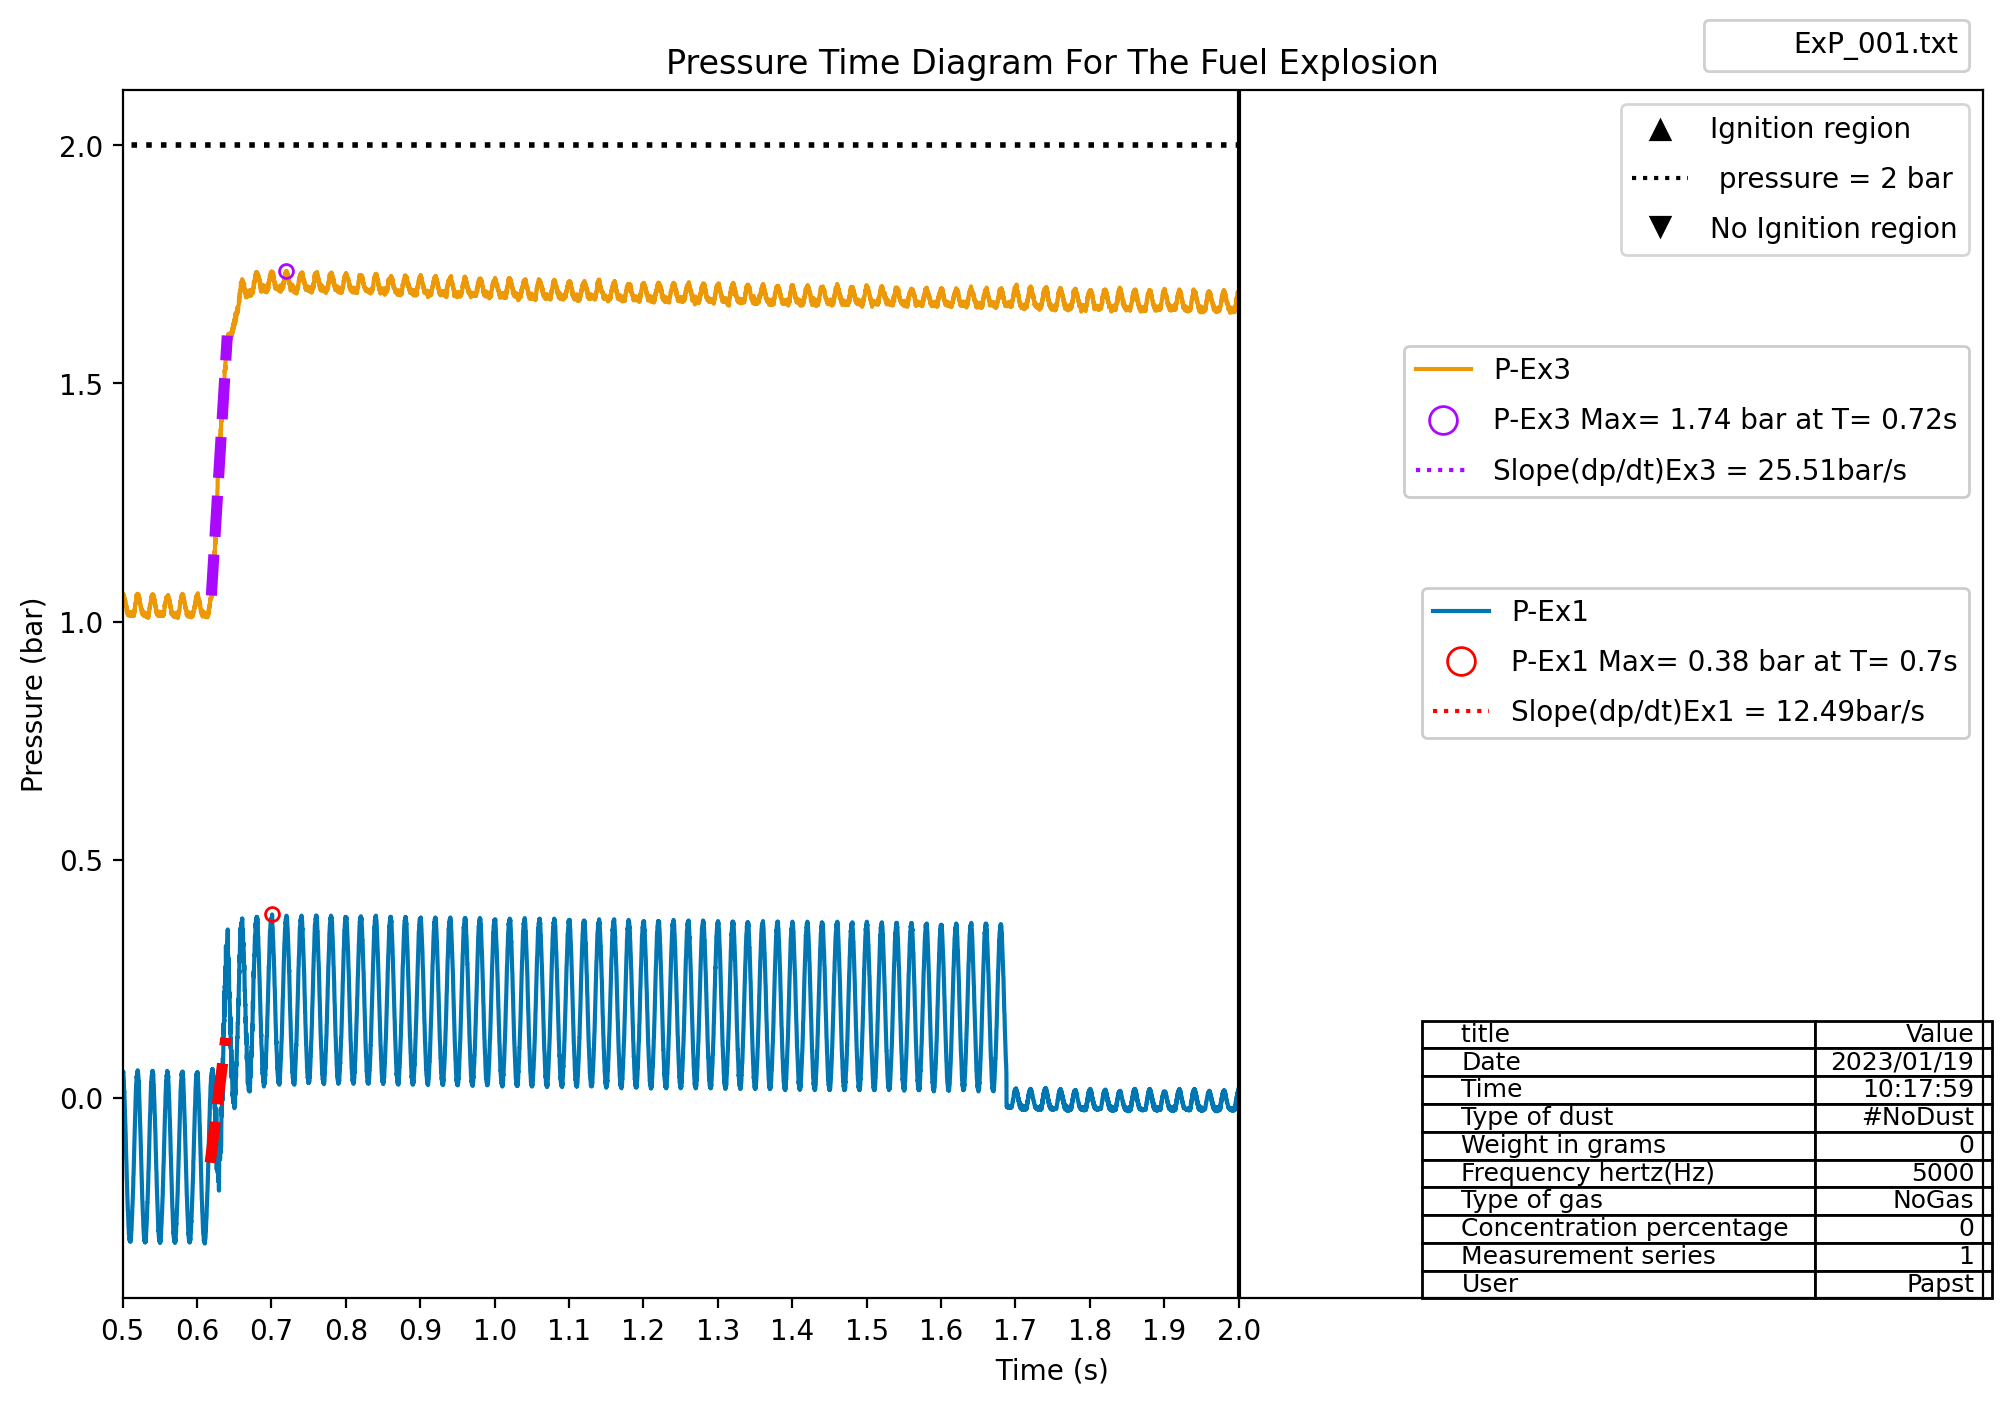

In [20]:
# prtin only on grath
path  = r"20230119/ExP_001.txt" # path for file 
path=path.replace('\\', '/')
pdf = mpdf.PdfPages("output2.pdf")
slope(path,pth=True)
pdf.close()

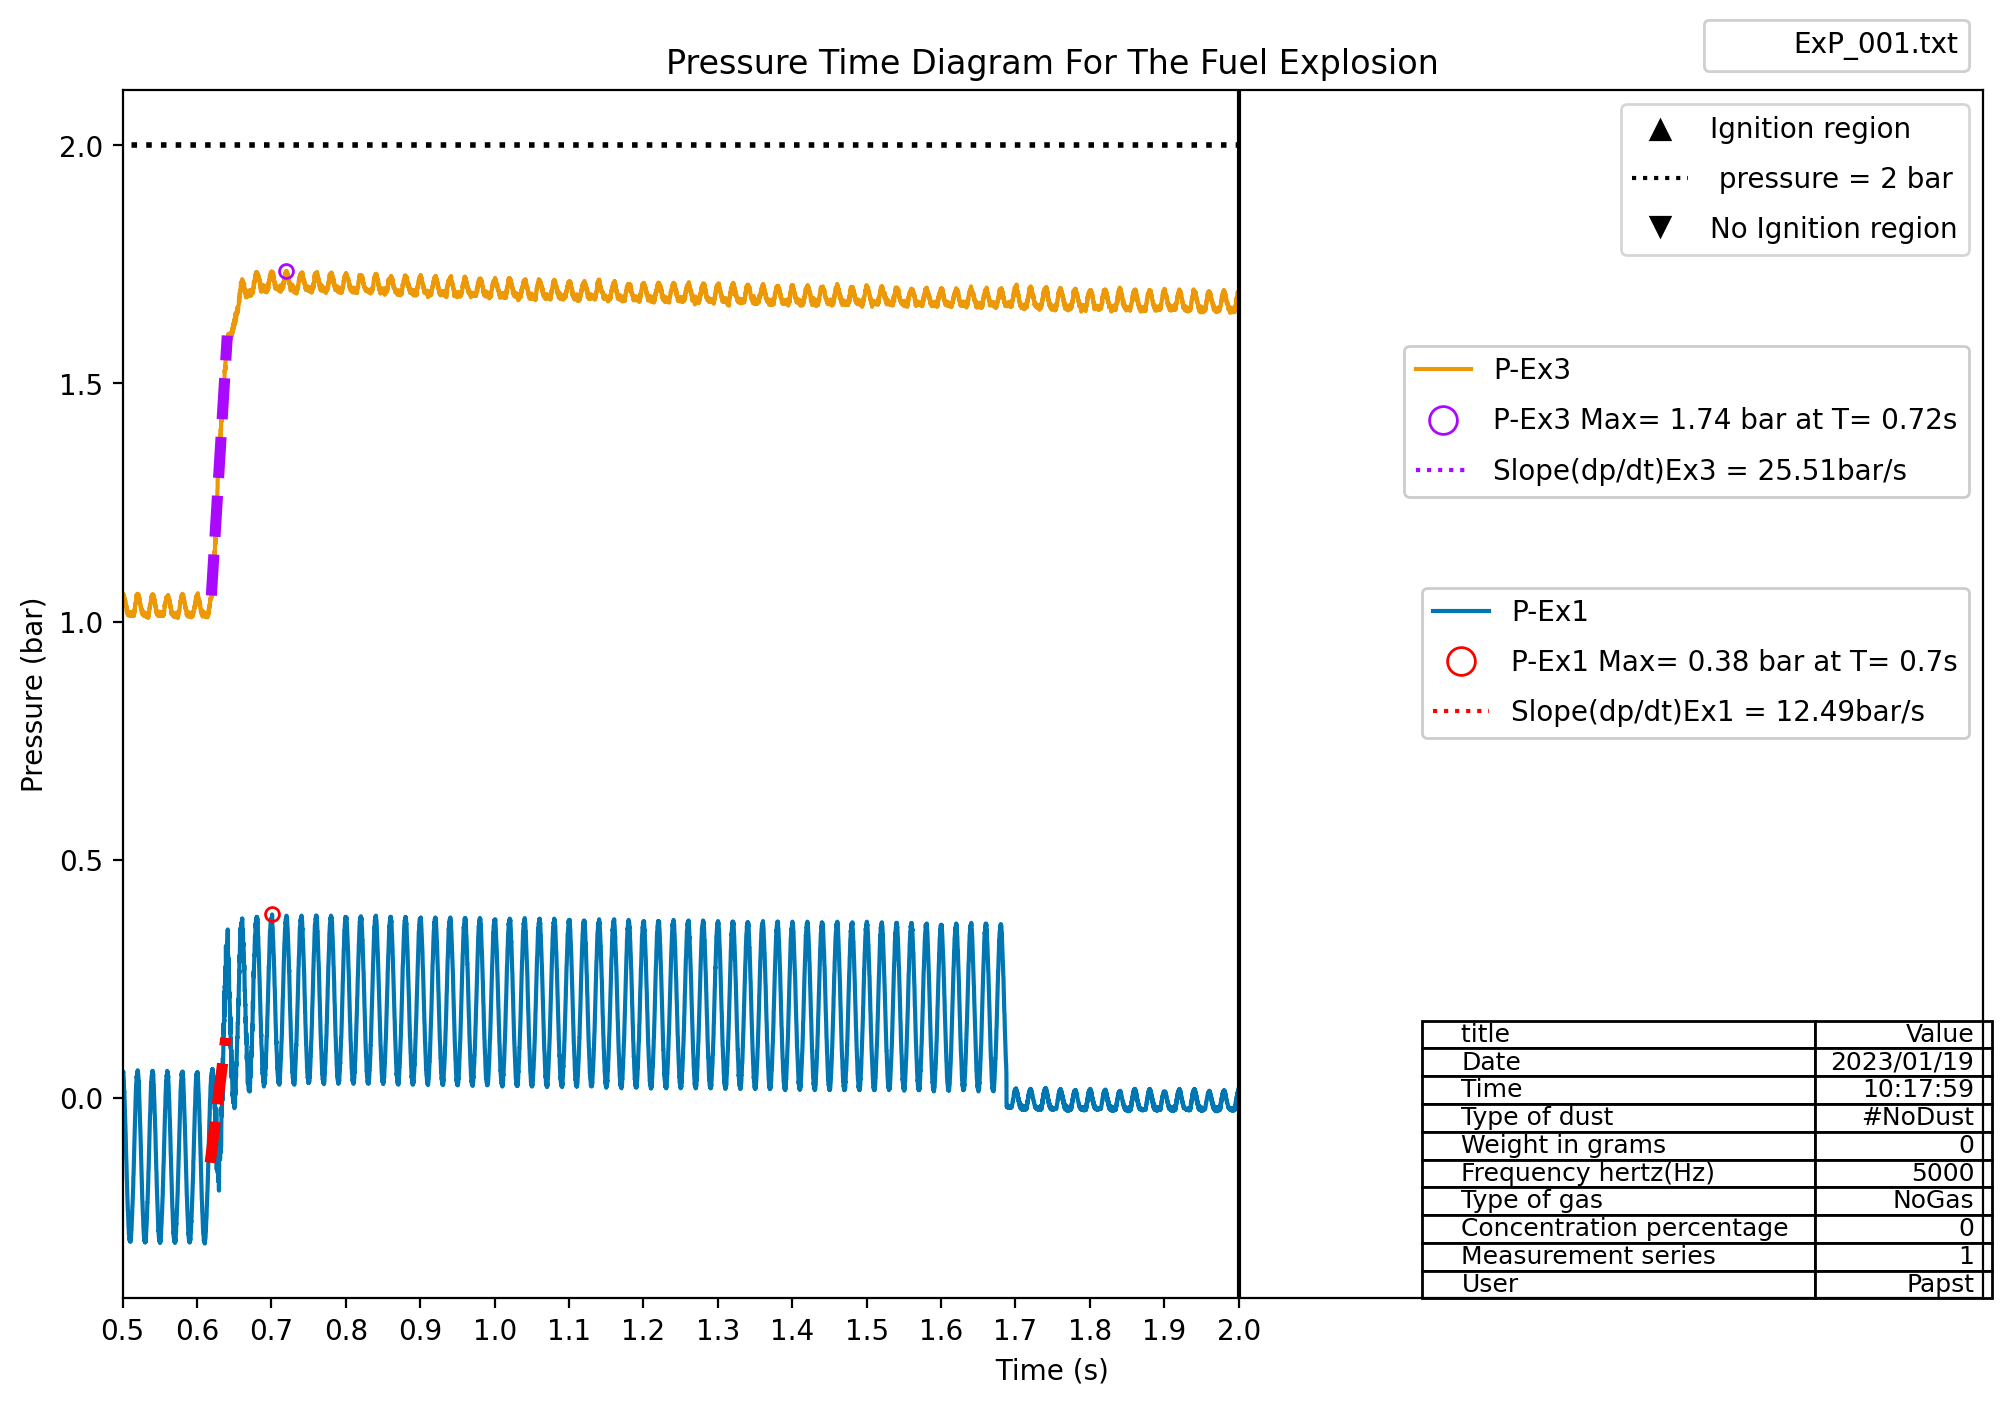

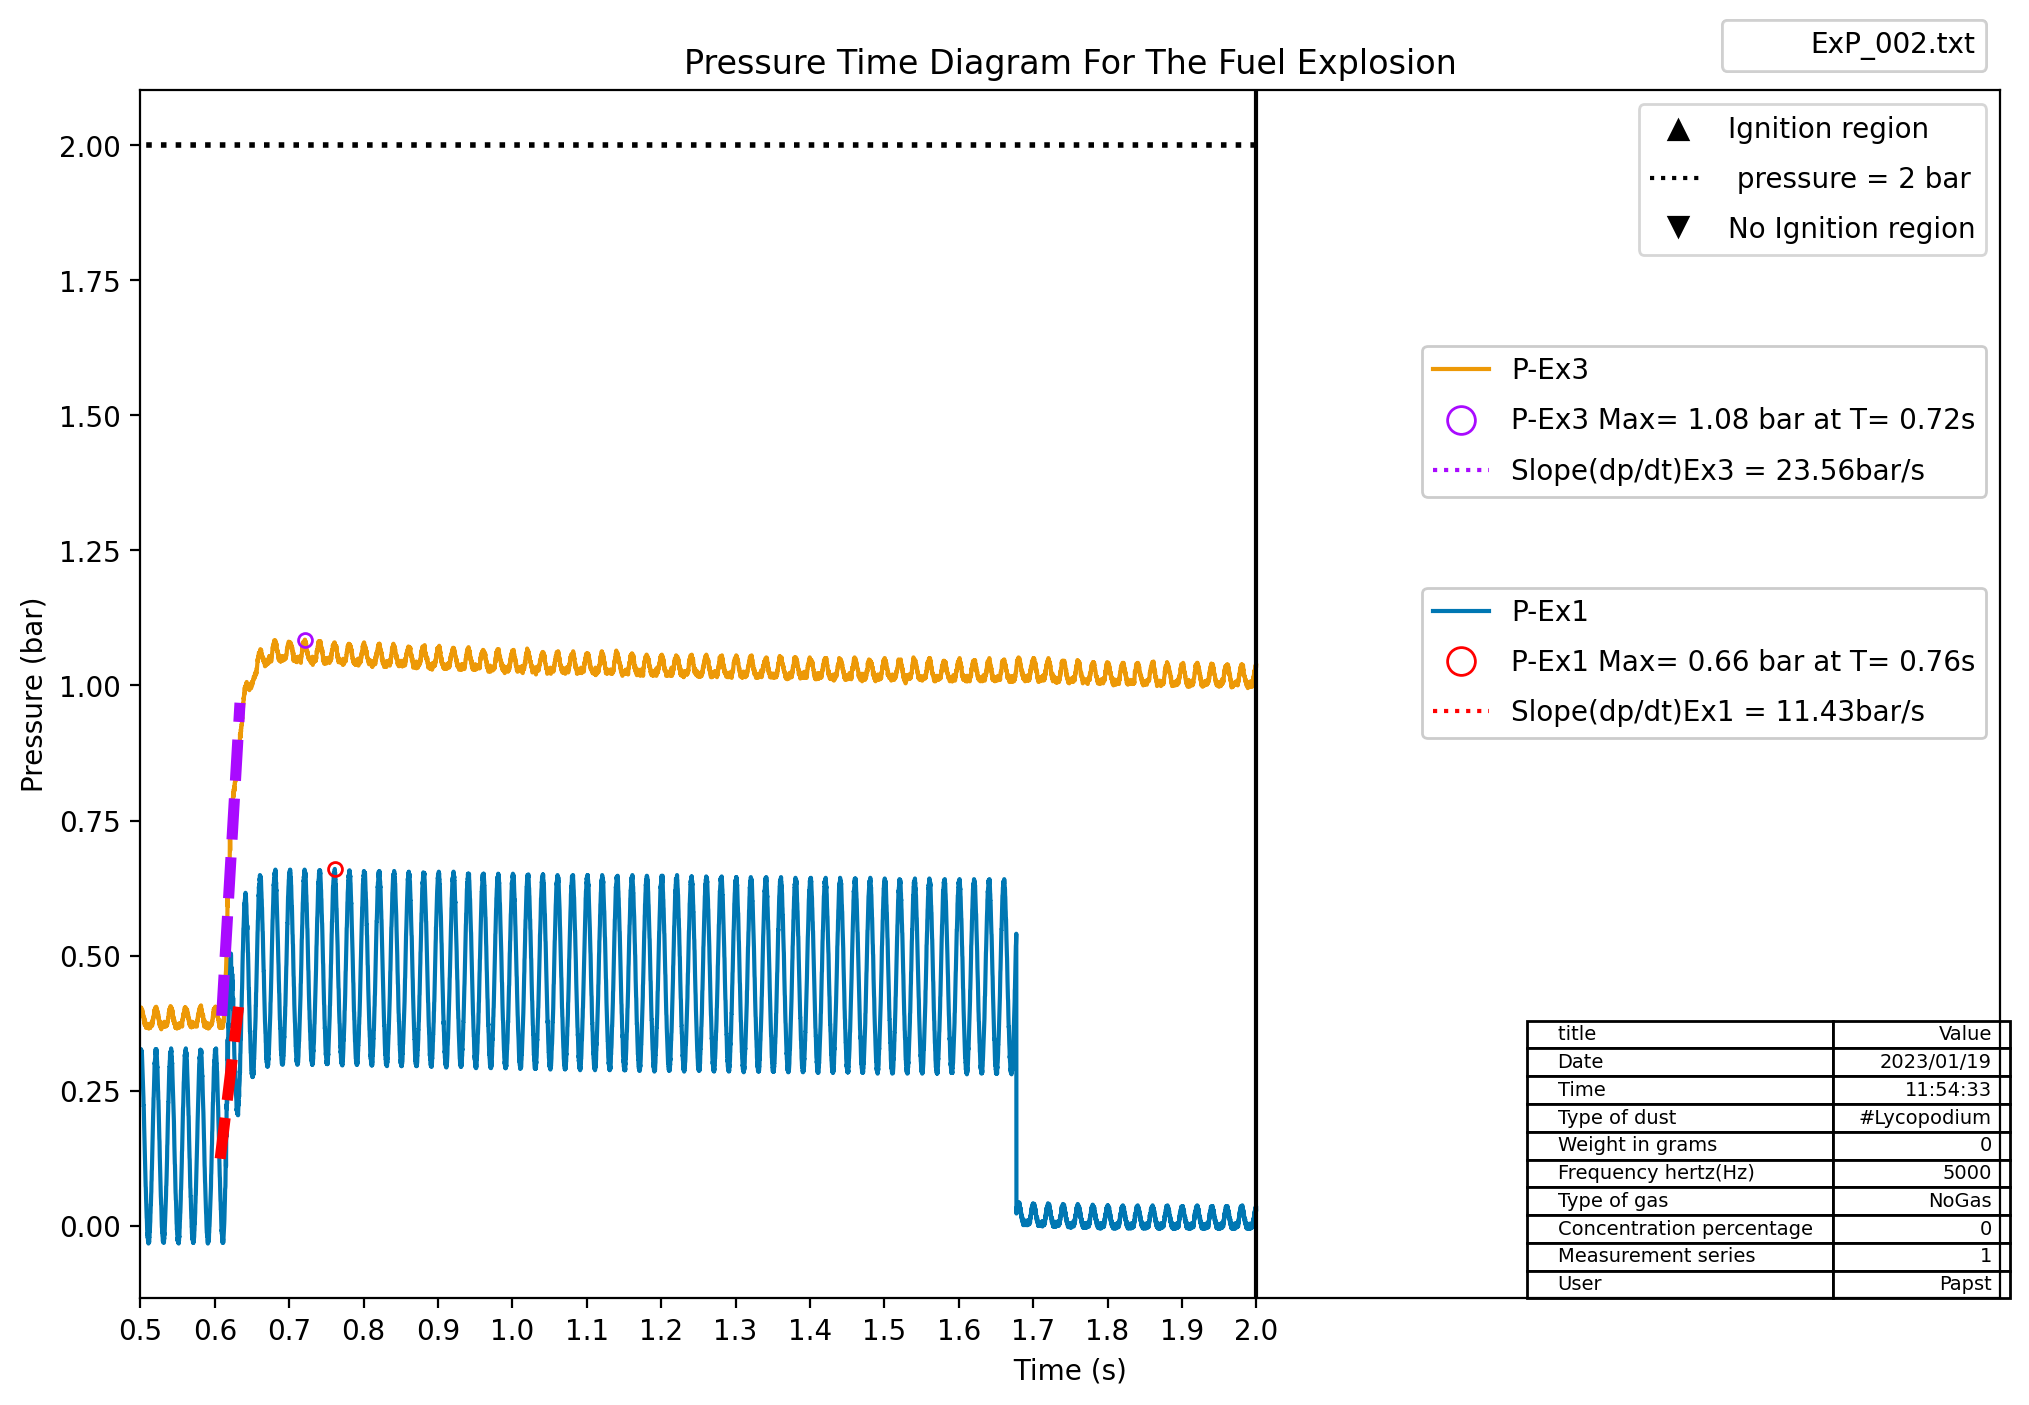

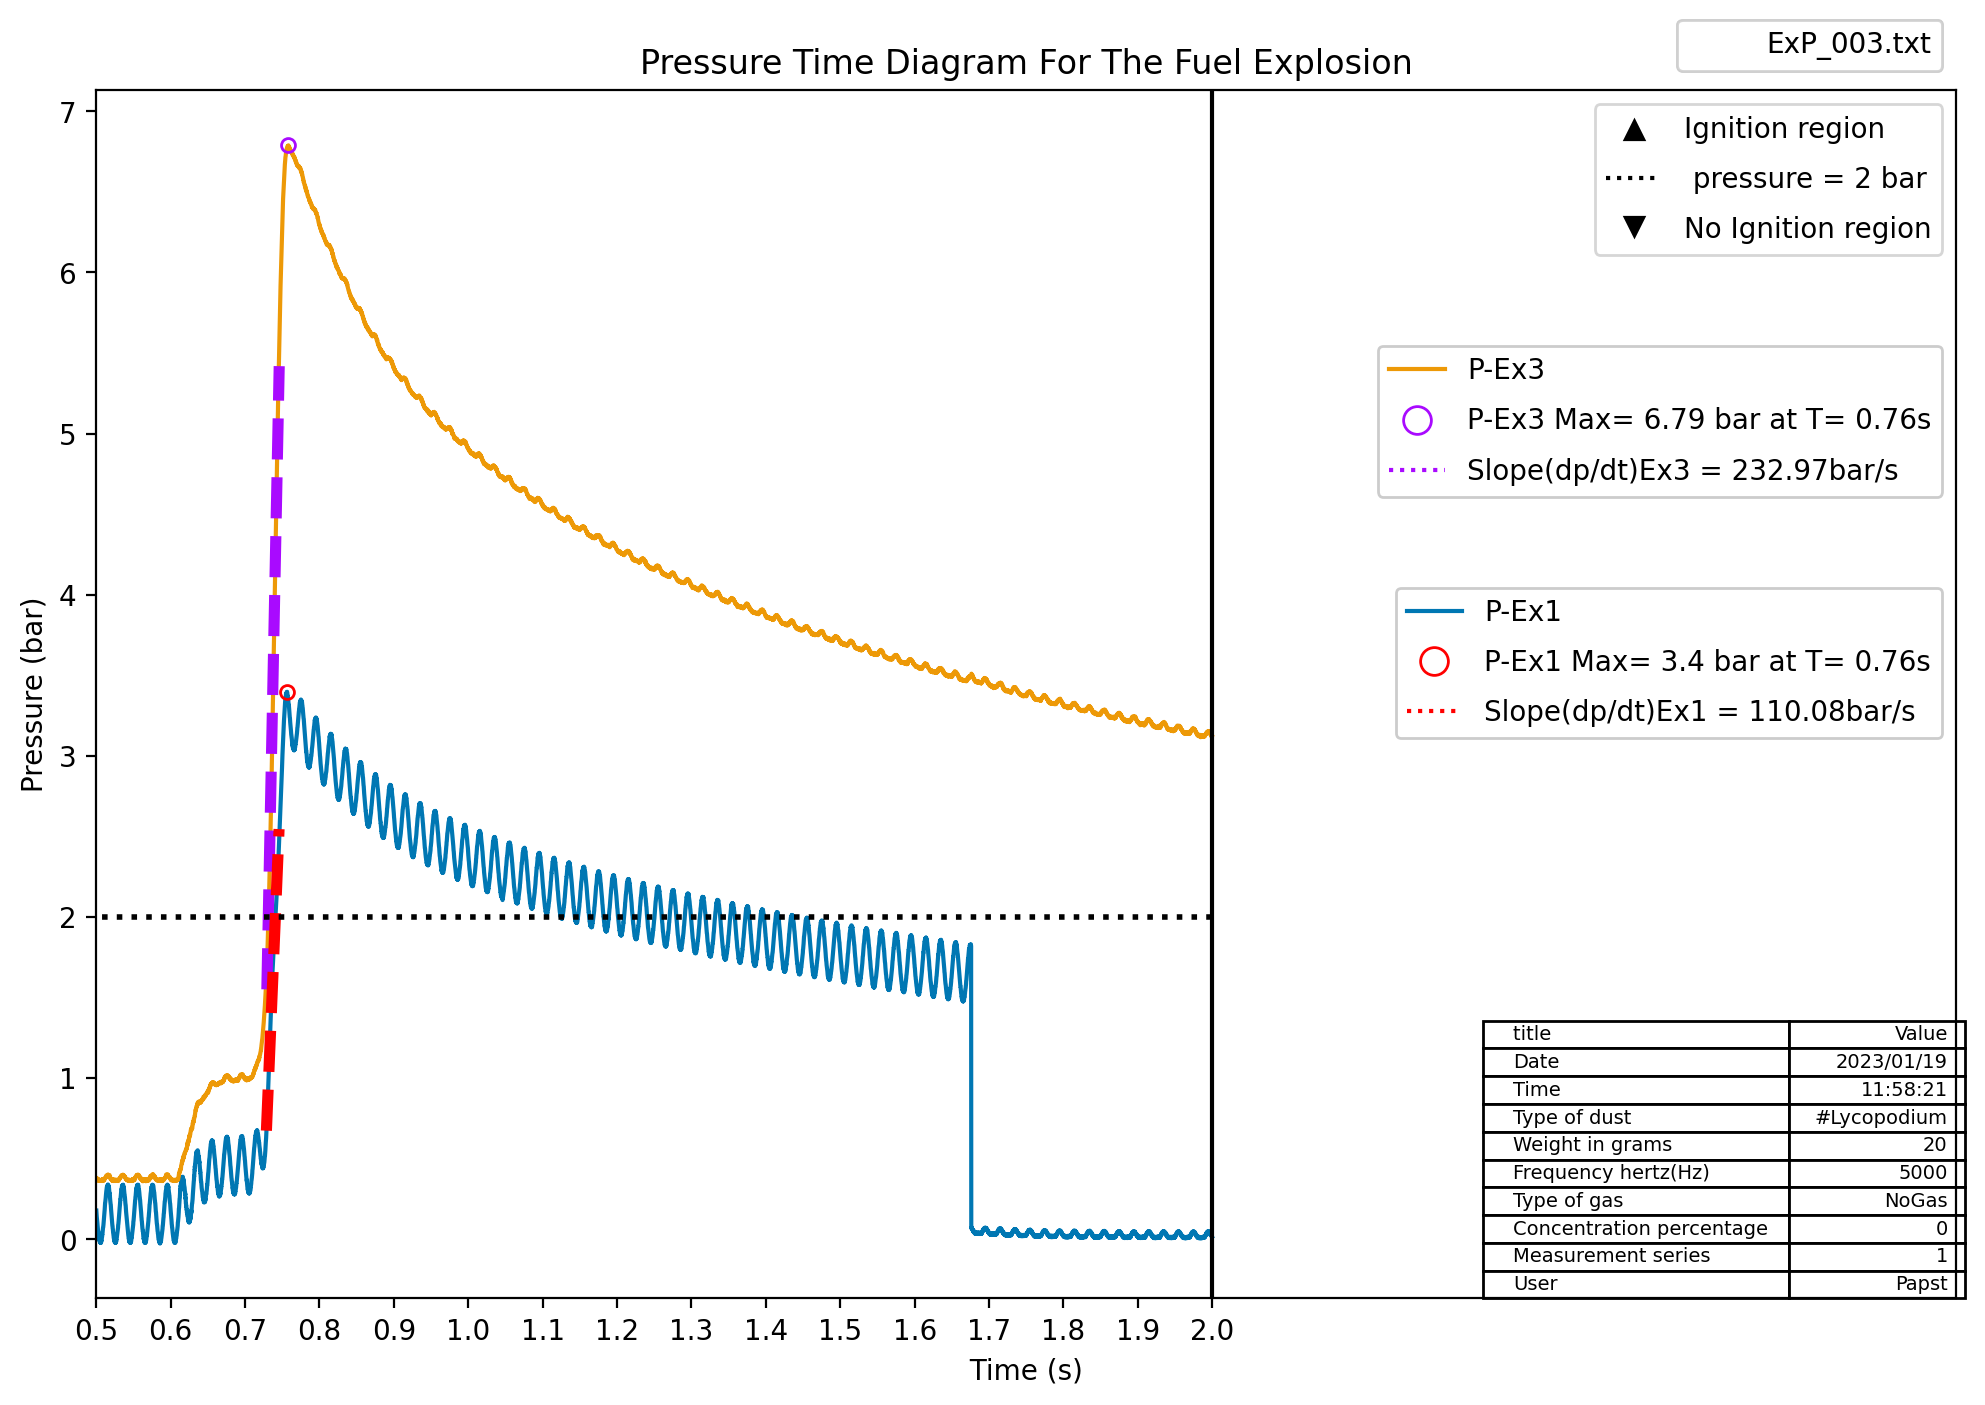

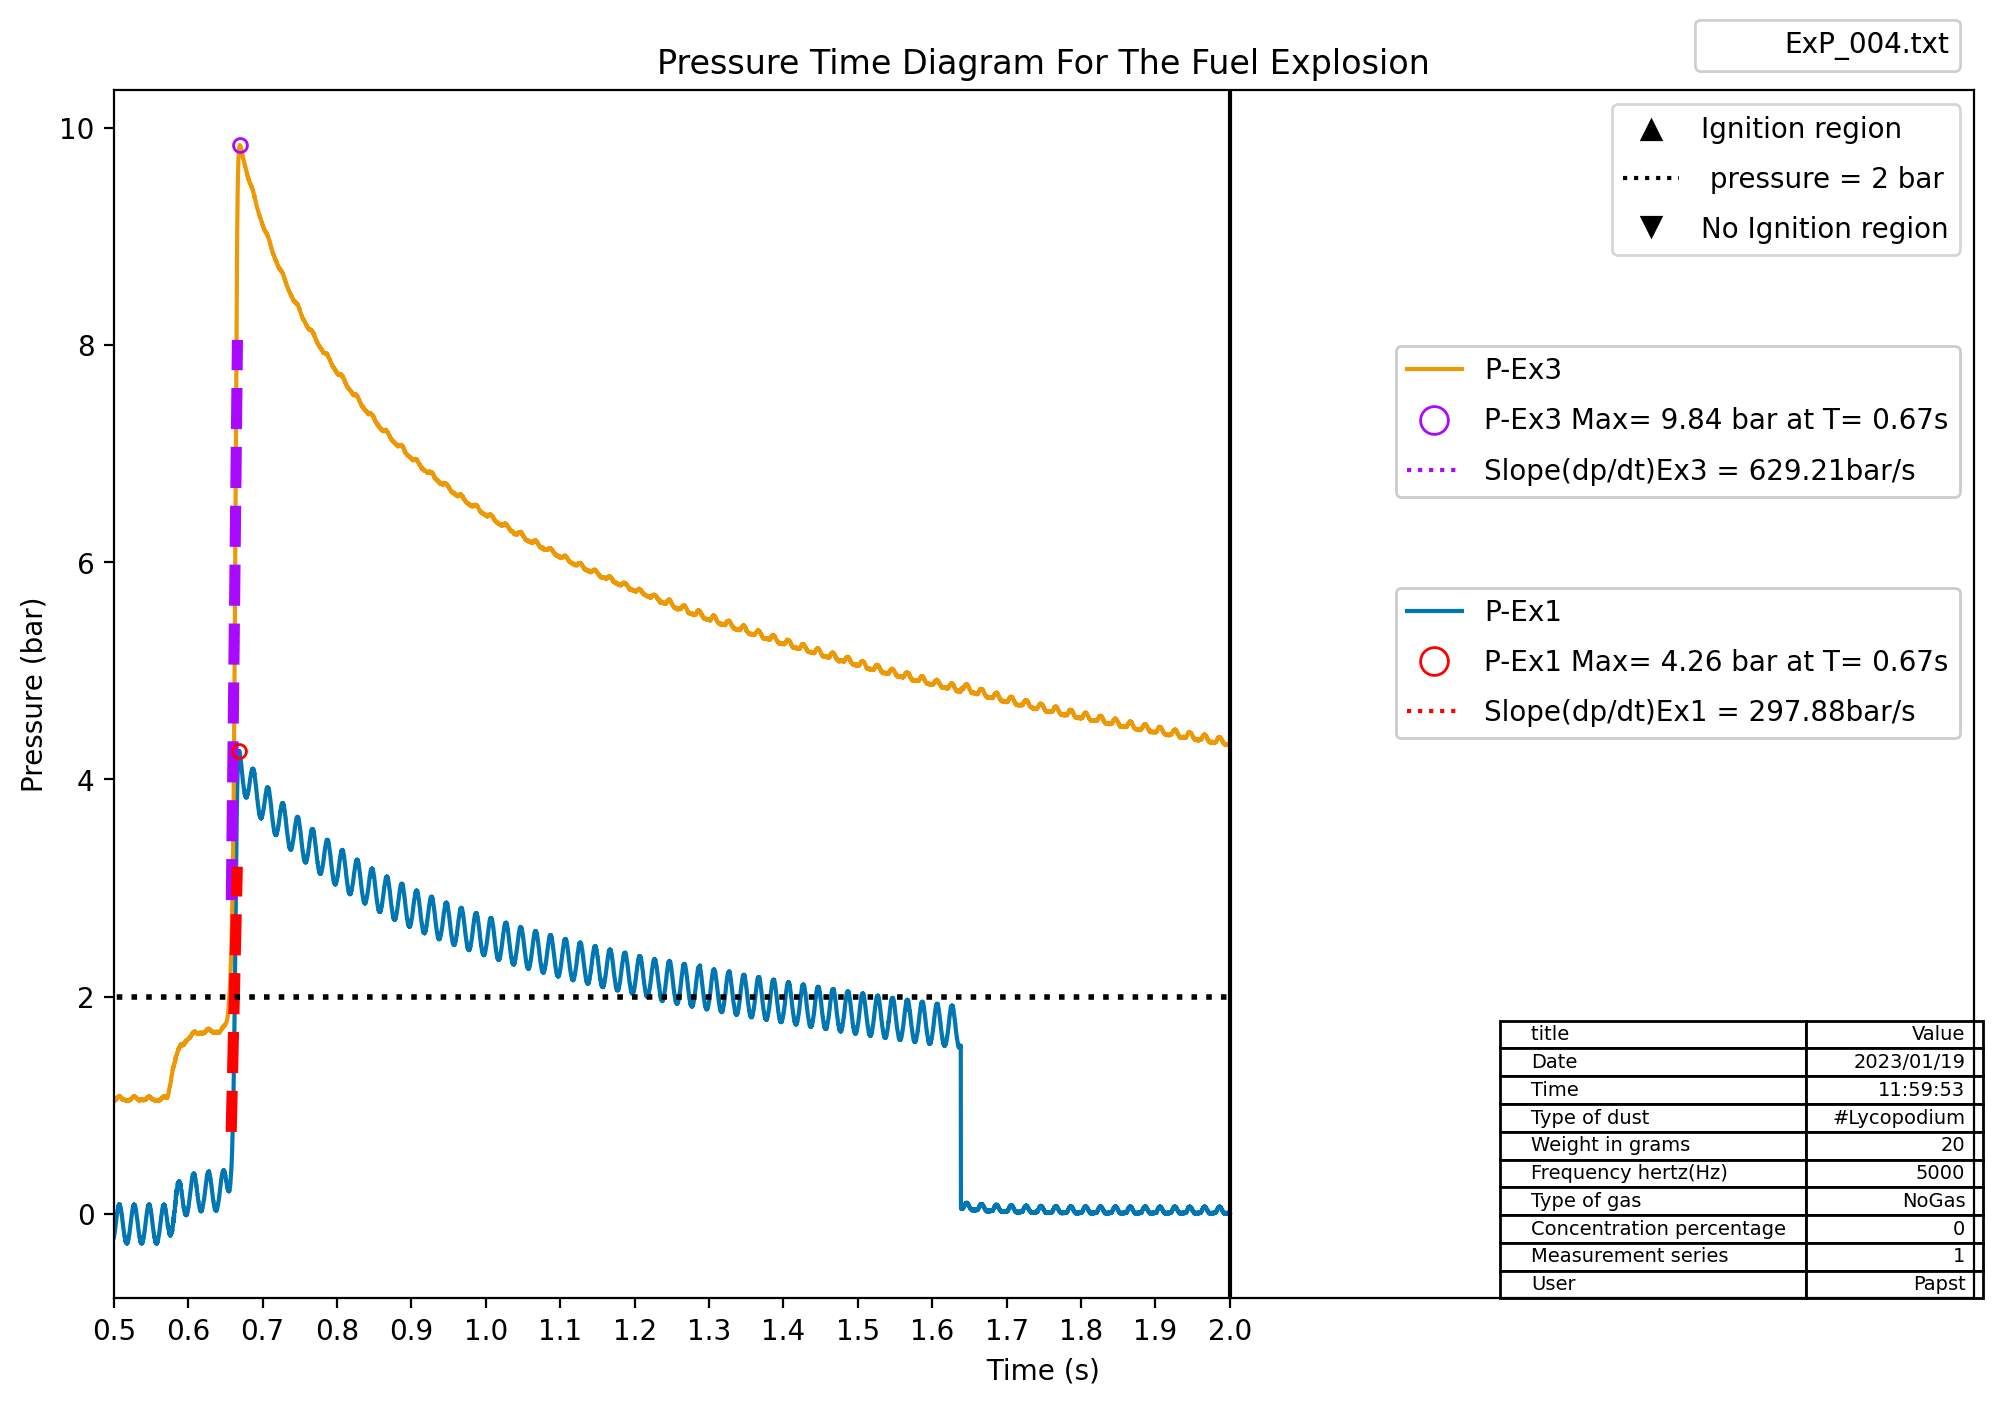

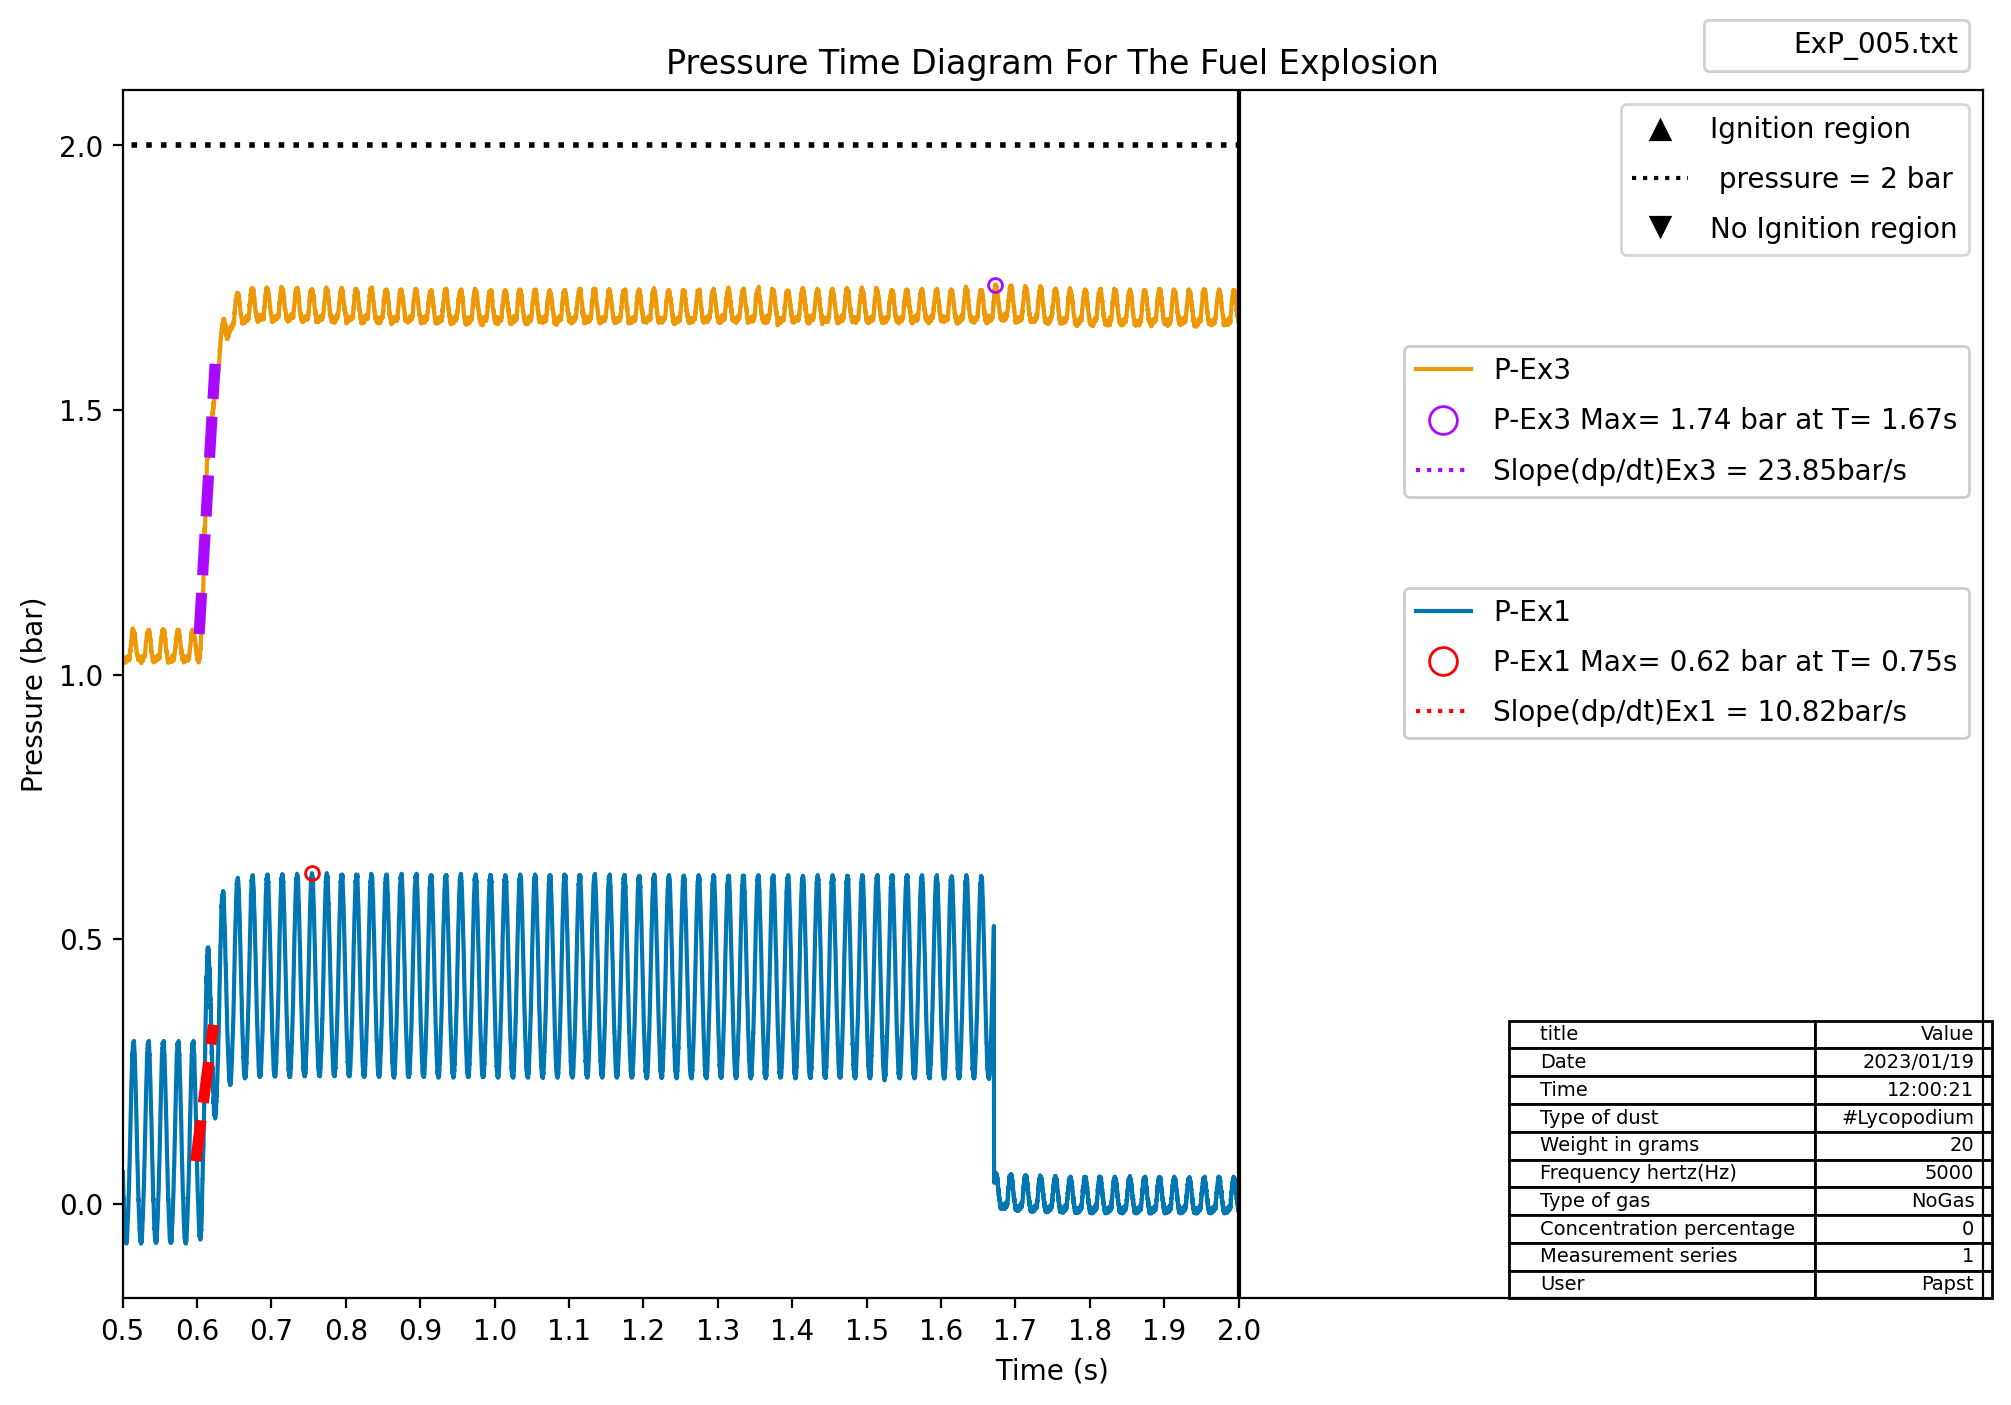

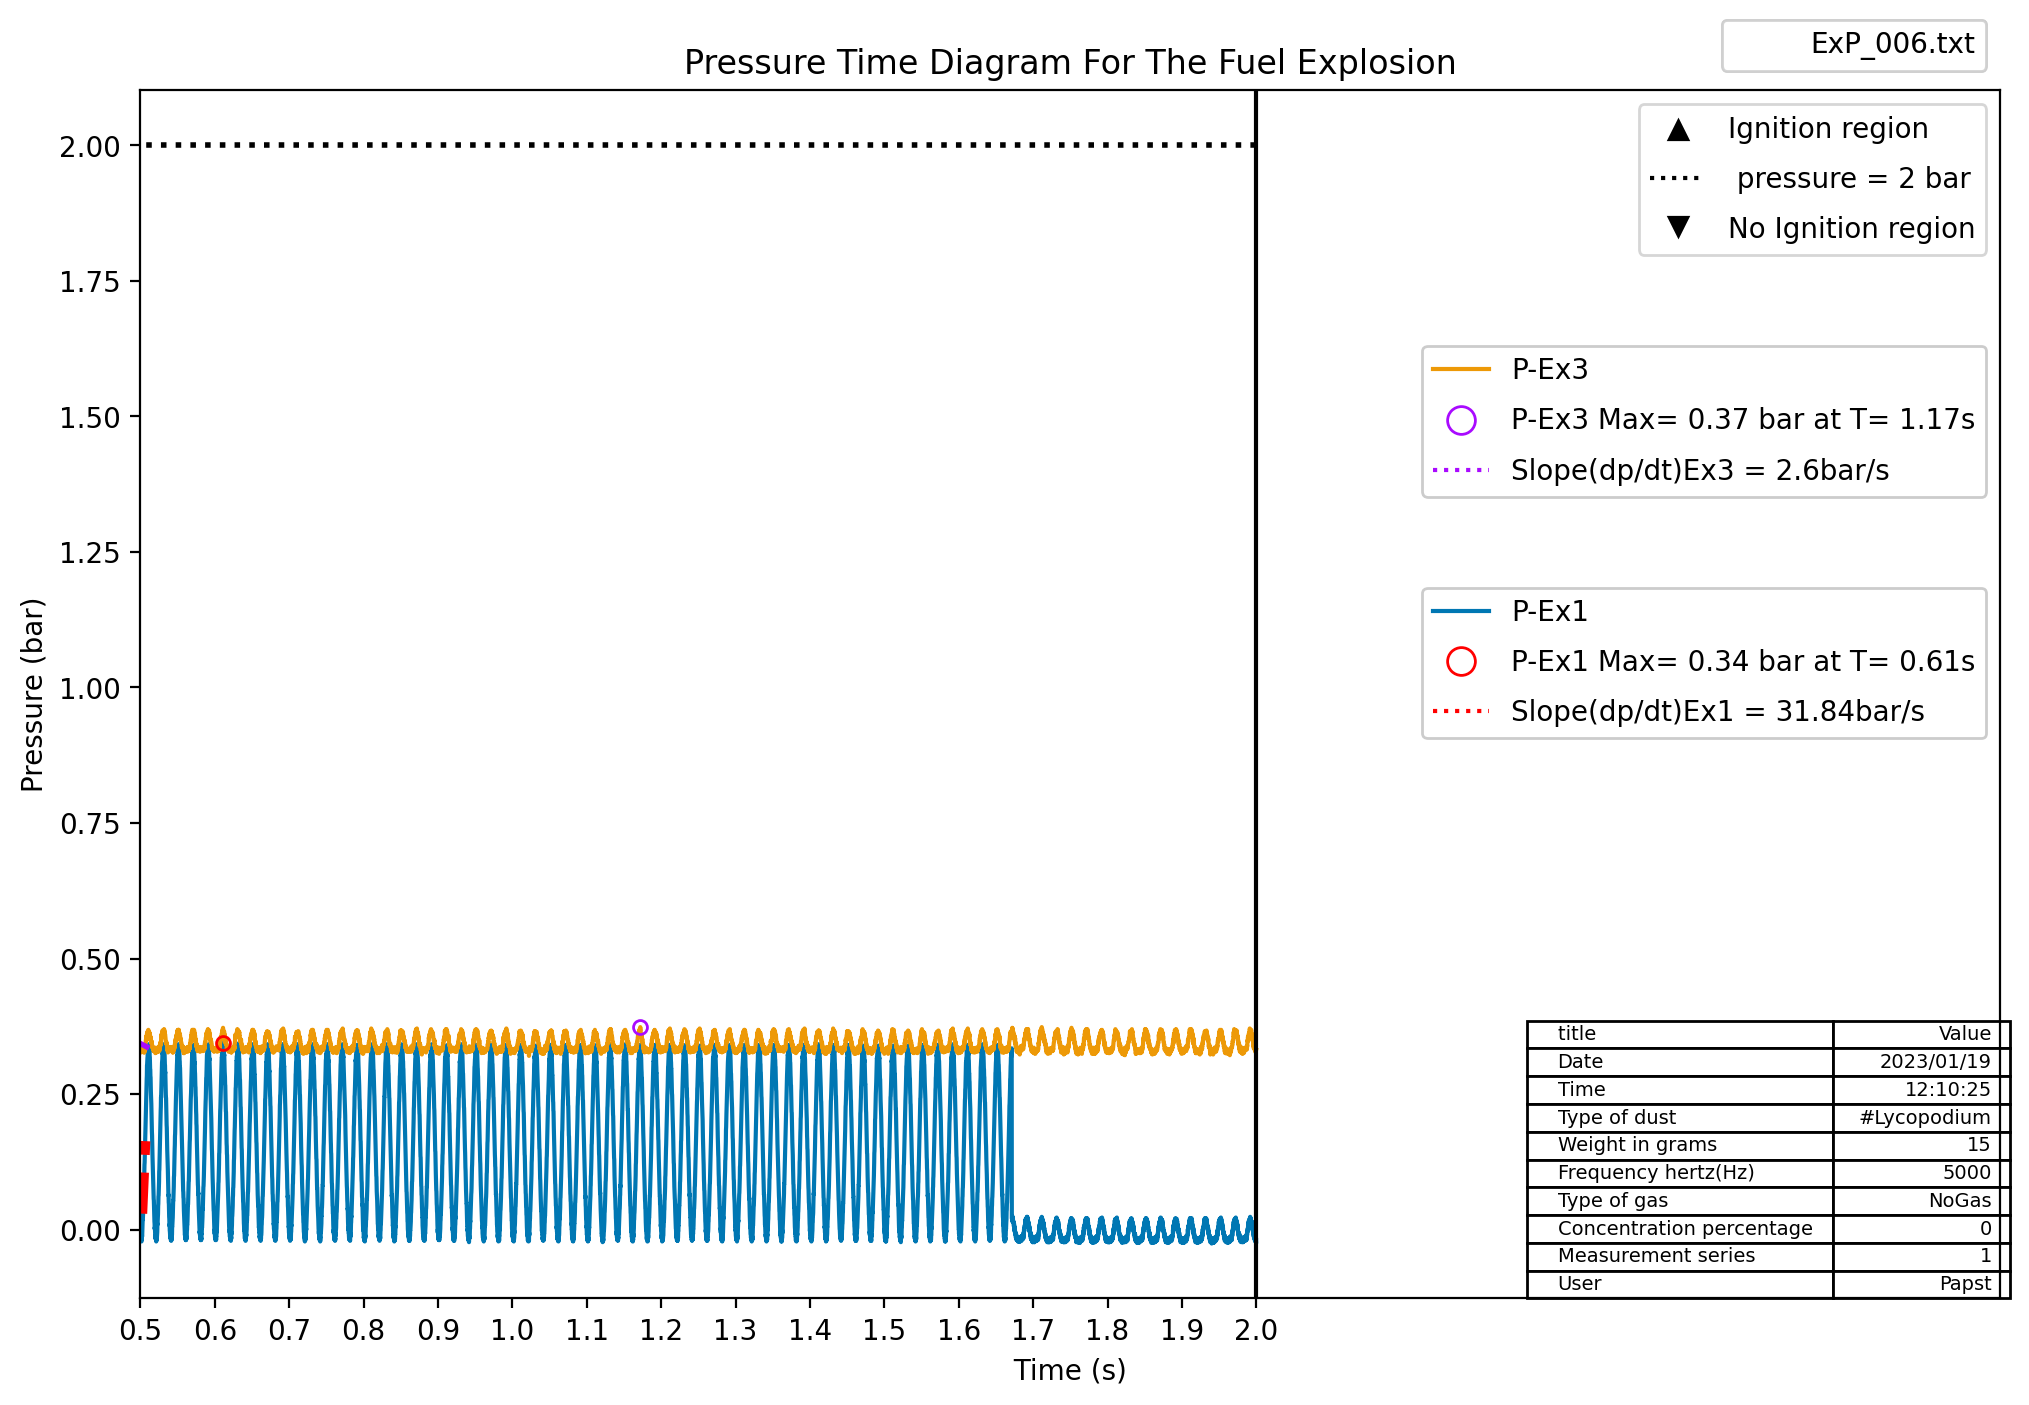

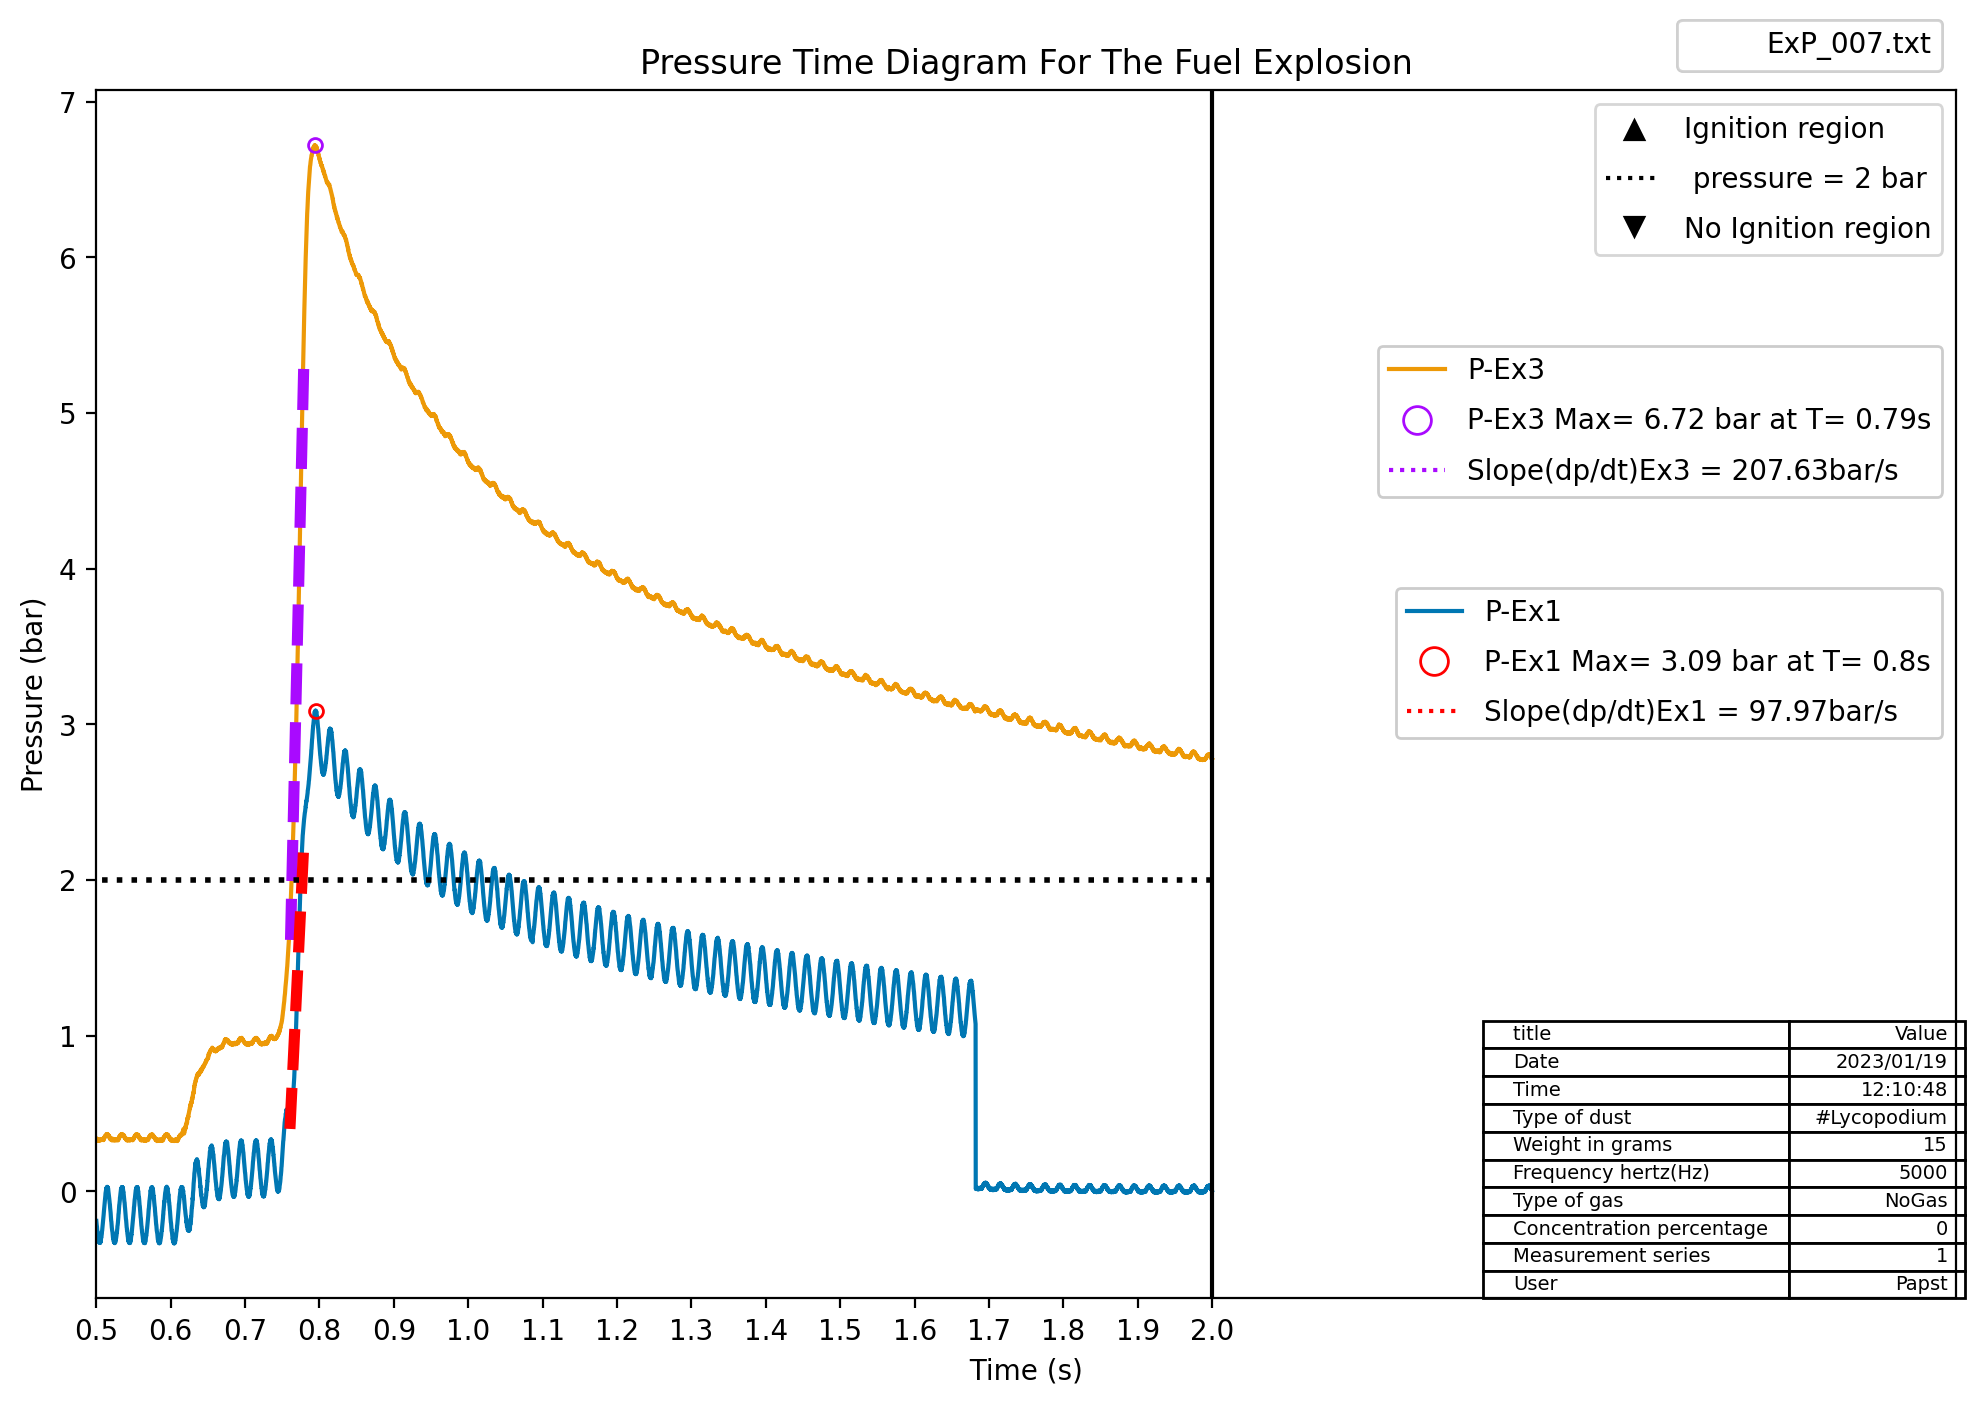

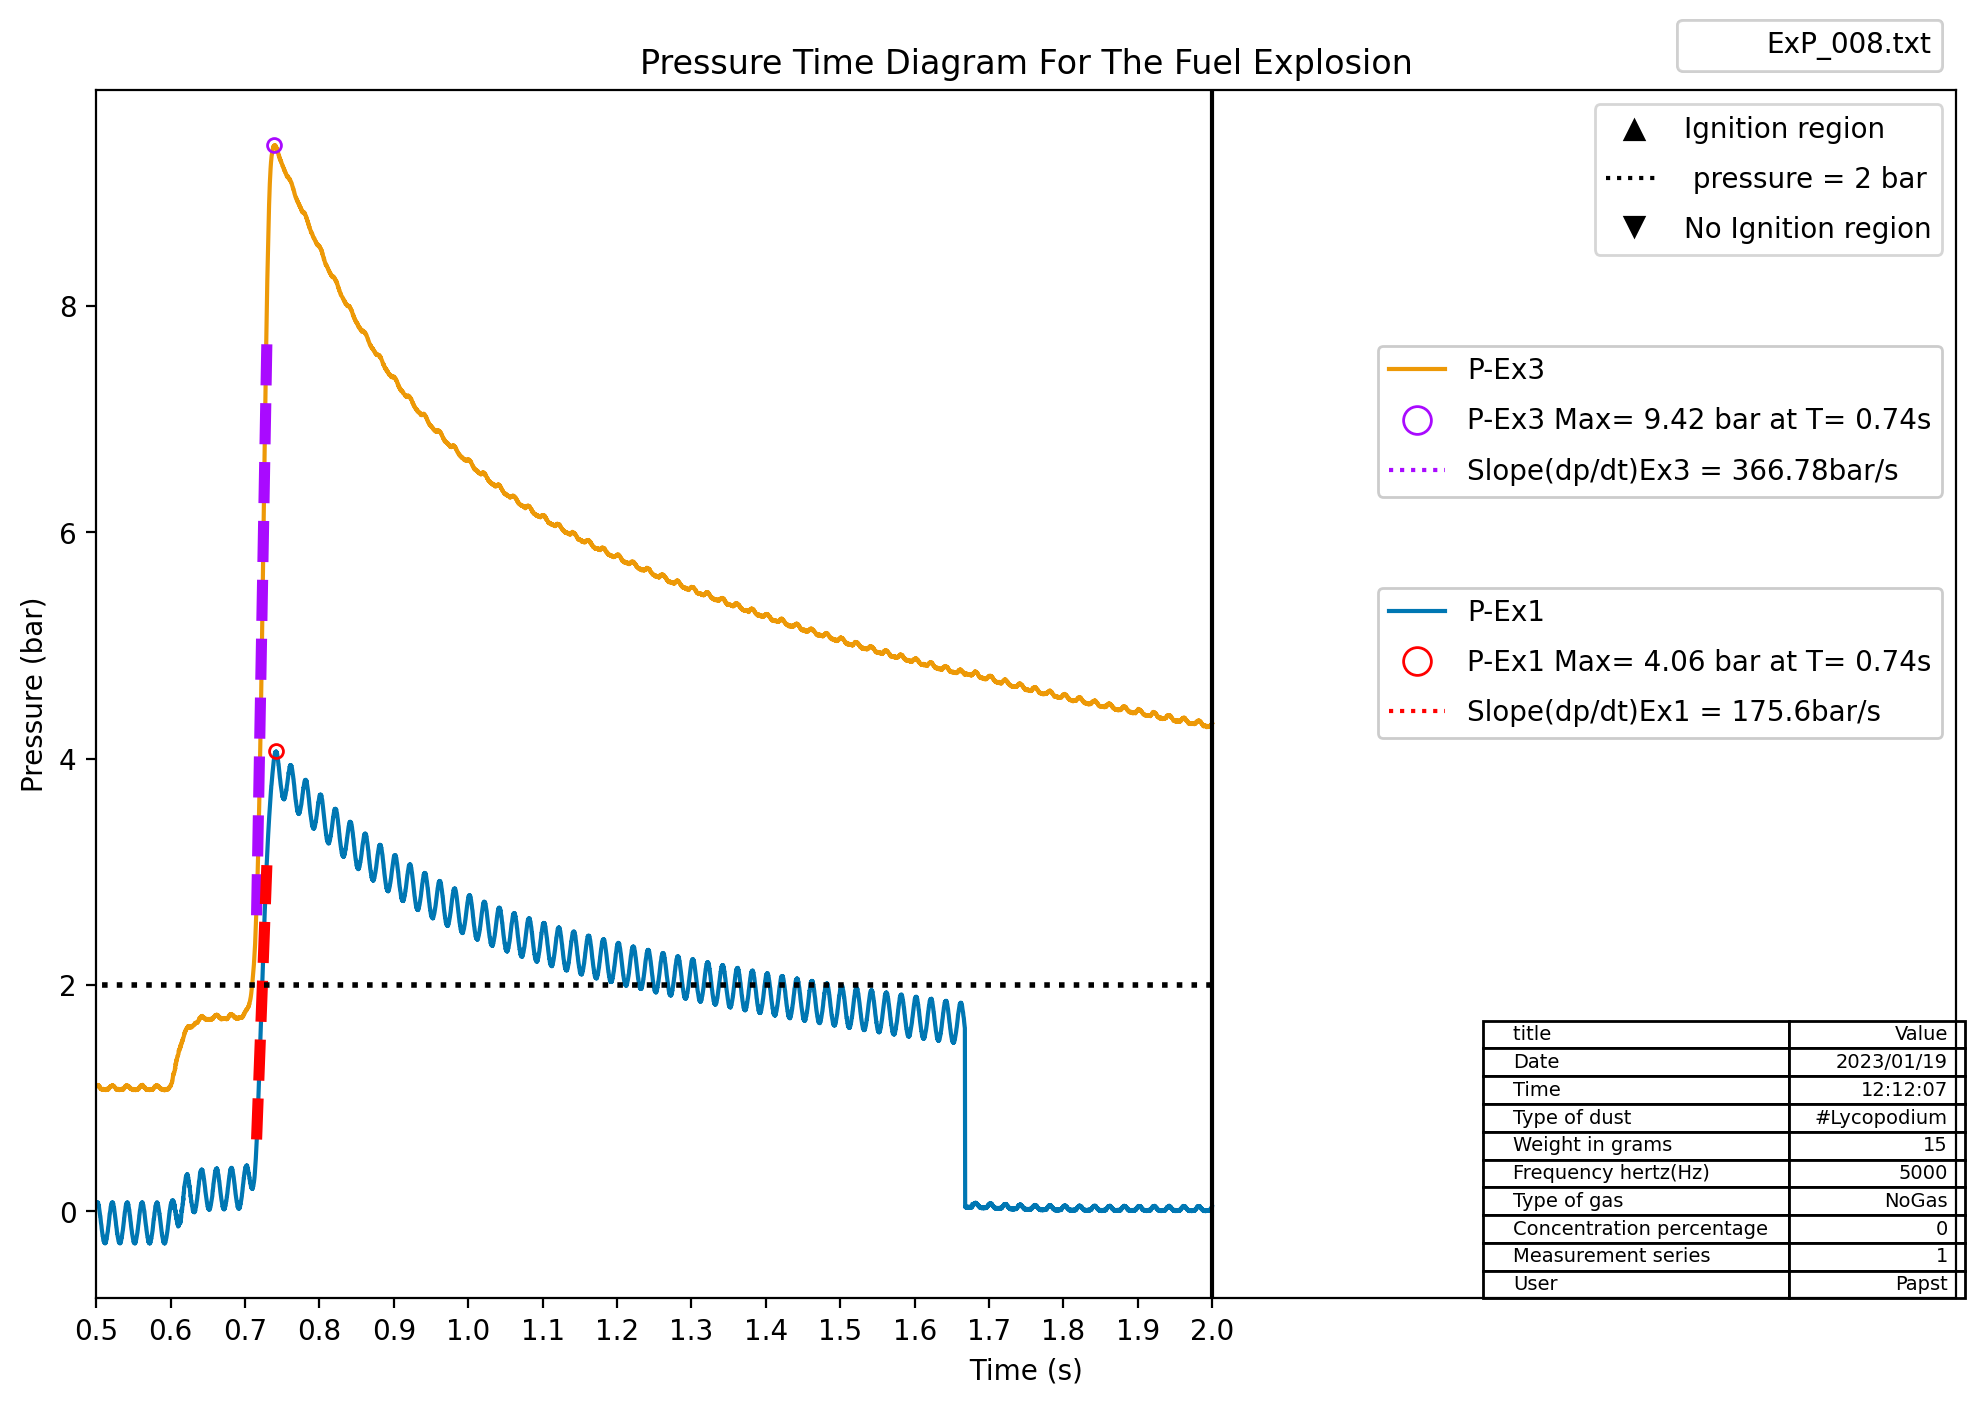

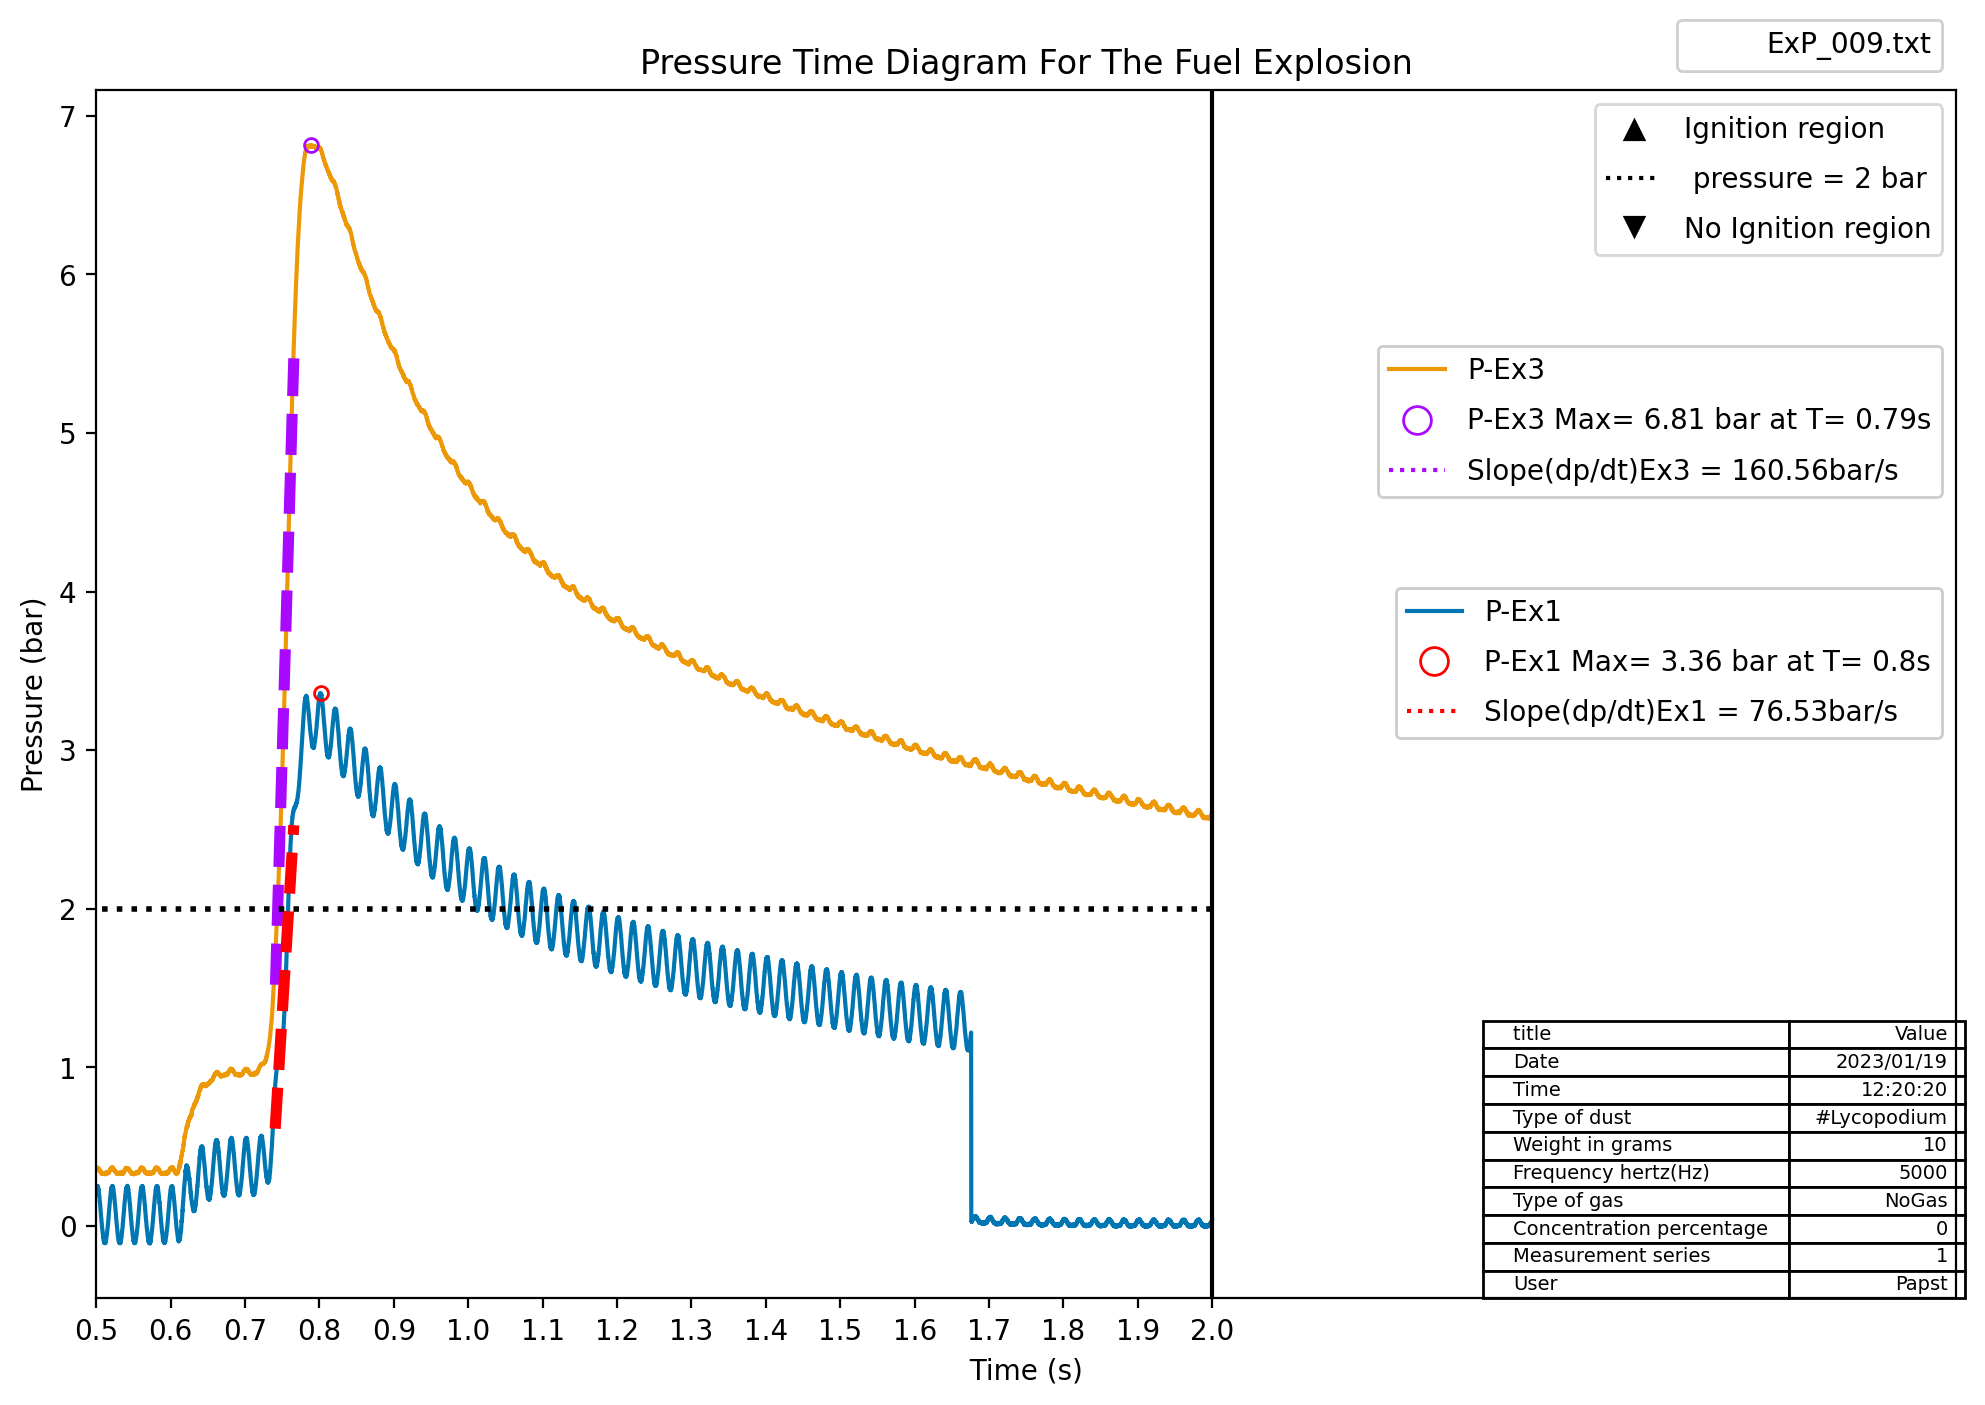

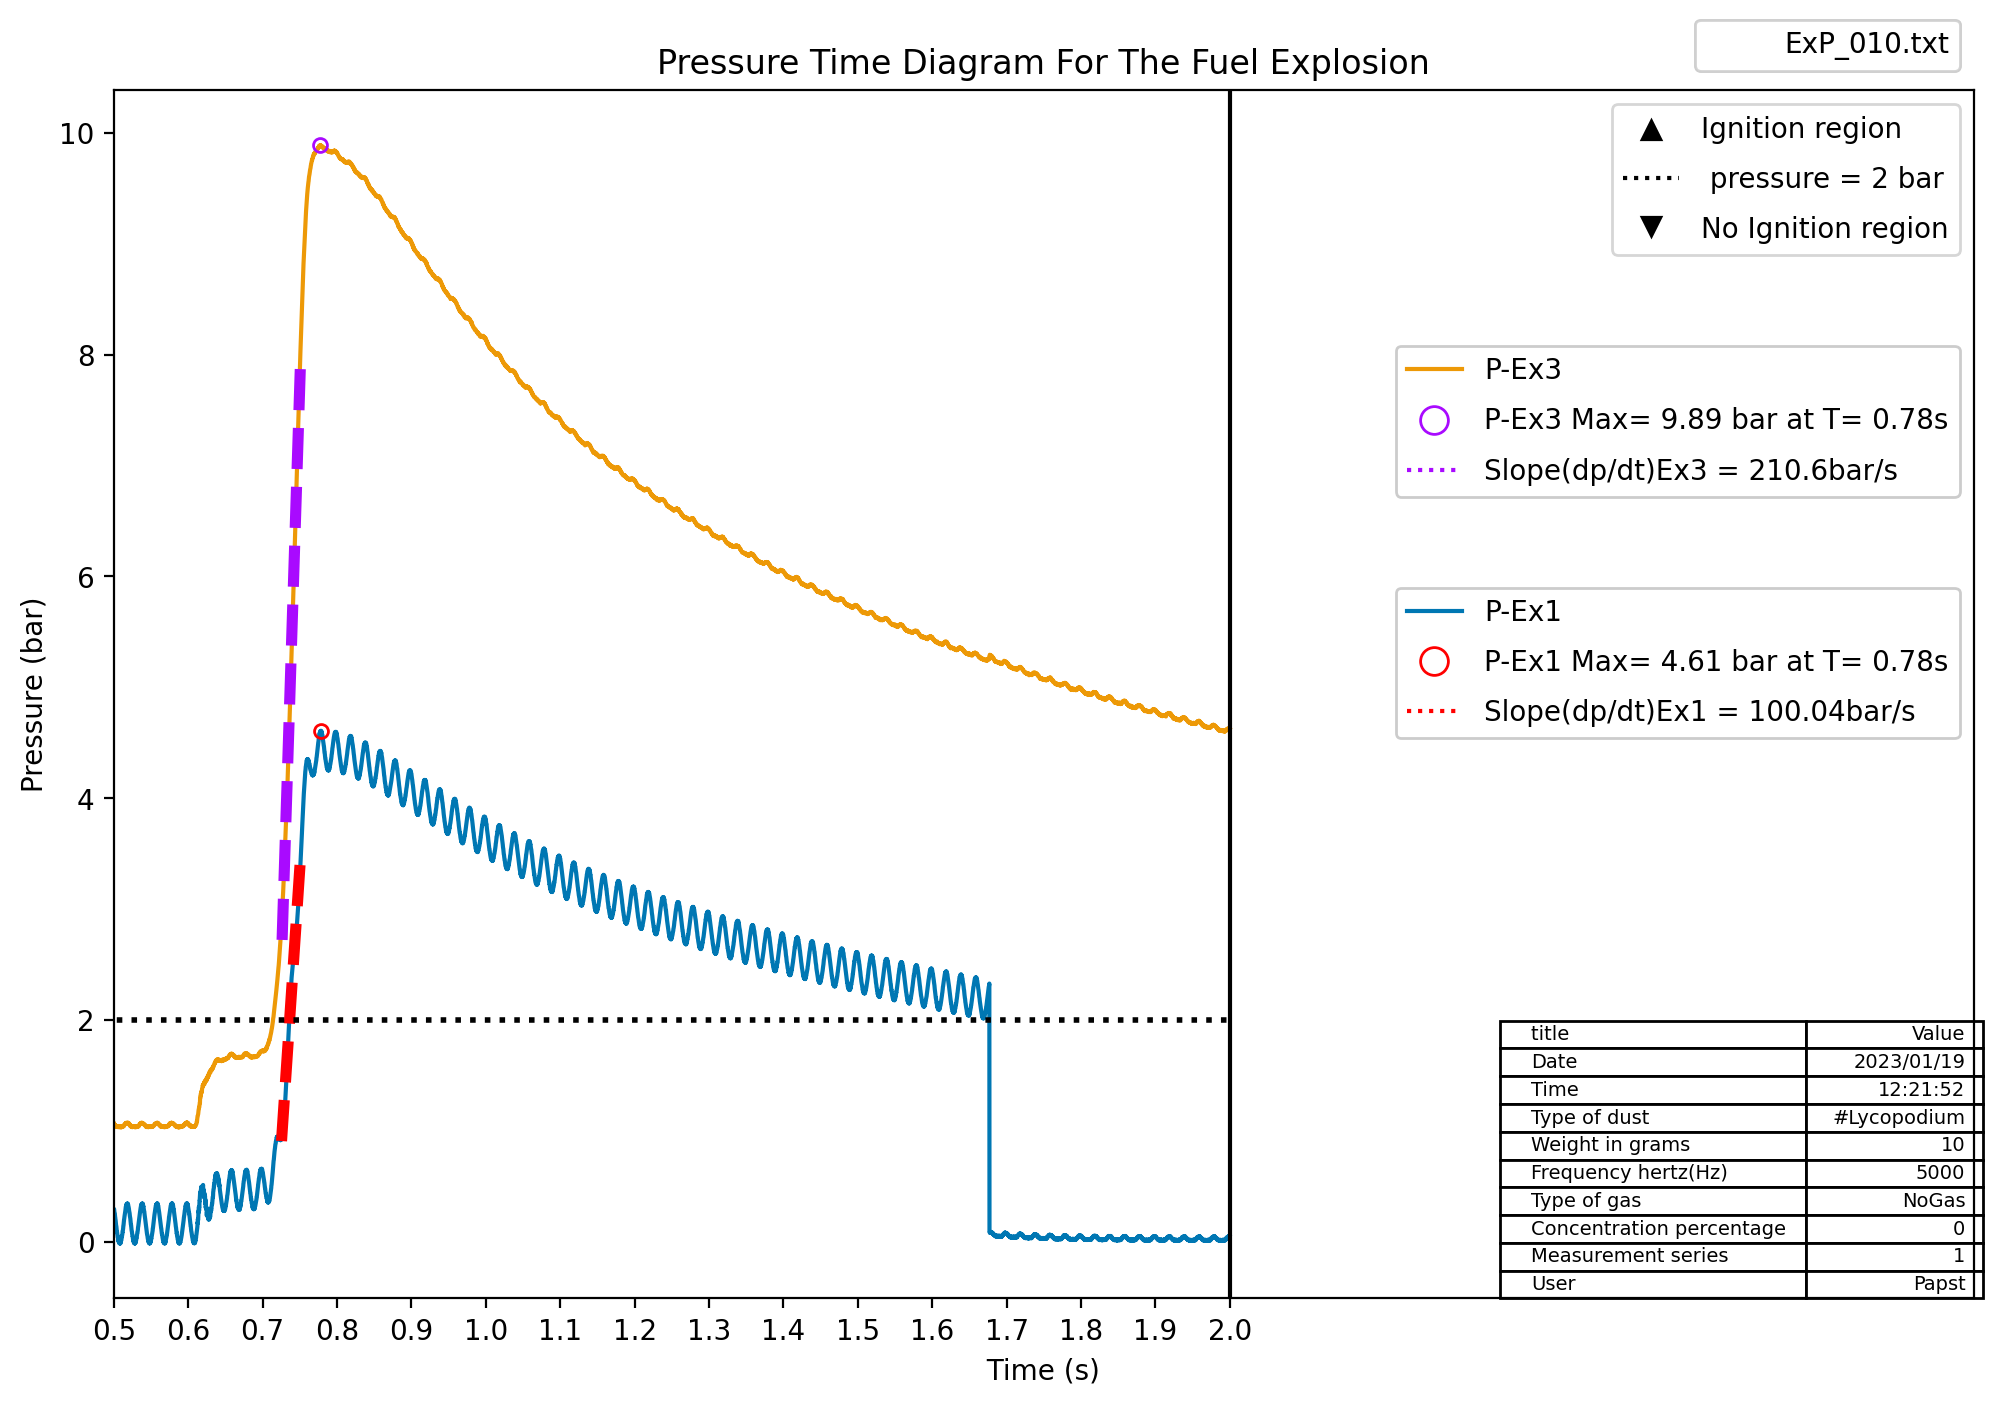

In [21]:
# print all graphs inside folder
path = r"20230119"   # folder path 

path=path.replace('\\', '/')+ '/*'
files =glob.glob(path)
files.sort()
pdf = mpdf.PdfPages("output2.pdf")
for file in files[:10] :
    try :
        slope(file ,pth=True)
    except :
        print(file)
pdf.close()